<a href="https://colab.research.google.com/github/RNEequalRNA/youtube-data-acquisition/blob/main/sample2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from helper import *

[nltk_data] Downloading package punkt to /home/hamerin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/hamerin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/hamerin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
positiveWords = pd.read_csv('positive.txt')['words']
negativeWords = pd.read_csv('negative.txt')['words']

In [ ]:
videoIdList = retrieve_playlist_videos('PLS3XGZxi7cBVTzEE4Sim9UuNKnUJq9Vkh')

In [ ]:
statisticsList = []
commentsList = []
commentsTimestamp = []

for id in videoIdList:
    statisticsList.append(retrieve_statistics(id))
    
    retries = 0
    while True:
        flag = True
        if retries >= 10:
            print("MAX RETRIES REACHED")
            commentsList.append([])
            commentsTimestamp.append([])
            break
        try:
            cl, ct = get_comments(id)
            commentsList.append(cl)
            commentsTimestamp.append(ct)
        except AssertionError:
            flag = False
            retries += 1
        finally:
            if flag:
                break

In [3]:
with open('data/videoid.txt', 'r') as f:
    exec(f"videoIdList = {f.read()}")
with open('data/statistics.txt', 'r') as f:
    exec(f"statisticsList = {f.read()}")
with open('data/comments.txt', 'r') as f:
    exec(f"commentsList = {f.read()}")
with open('data/timestamp.txt', 'r') as f:
    exec(f"commentsTimestamp = {f.read()}")

In [13]:
len(commentsList), sum(map(lambda x: len(x), commentsList))

(50, 22326)

In [4]:
allComments = []
for comments in commentsList: allComments += comments

freqDataFrame = get_freq(allComments)
freqDataFrame

,word,freq
1157,israel,3743
38,people,2607
434,god,1649
20,one,1621
297,world,1521
...,...,...
11658,avenged,1
11659,boxing,1
11660,slogan,1
11661,metaphor,1


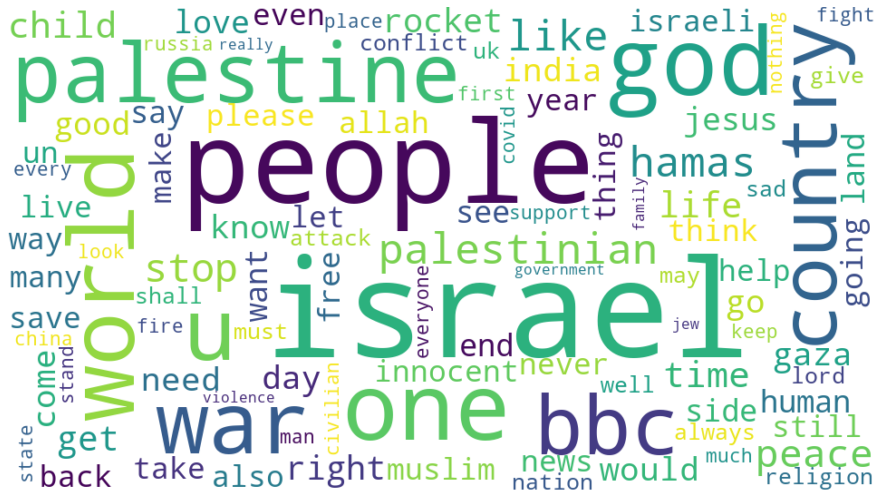

In [5]:
draw_wordcloud(freqDataFrame)

In [6]:
words = []
times = []
for i in tqdm(range(len(videoIdList))):
    for j in range(len(commentsList[i])):
        time = parse(commentsTimestamp[i][j]).timestamp()
        
        for word in get_words(commentsList[i][j]):
            words.append(word)
            times.append(time)


wordtimeDataFrame = pd.DataFrame(columns=['word', 'time'], data={
    'word': words,
    'time': times
})

100%|██████████| 50/50 [00:06<00:00,  7.30it/s]


In [8]:
PARTITION_SIZE = 15
bins = np.linspace(min(wordtimeDataFrame['time']), max(wordtimeDataFrame['time']), PARTITION_SIZE + 1) 

array([[<AxesSubplot:title={'center':'time'}>]], dtype=object)

array([[<AxesSubplot:title={'center':'time'}>]], dtype=object)

array([[<AxesSubplot:title={'center':'time'}>]], dtype=object)

array([[<AxesSubplot:title={'center':'time'}>]], dtype=object)

array([[<AxesSubplot:title={'center':'time'}>]], dtype=object)

array([[<AxesSubplot:title={'center':'time'}>]], dtype=object)

array([[<AxesSubplot:title={'center':'time'}>]], dtype=object)

array([[<AxesSubplot:title={'center':'time'}>]], dtype=object)

array([[<AxesSubplot:title={'center':'time'}>]], dtype=object)

array([[<AxesSubplot:title={'center':'time'}>]], dtype=object)

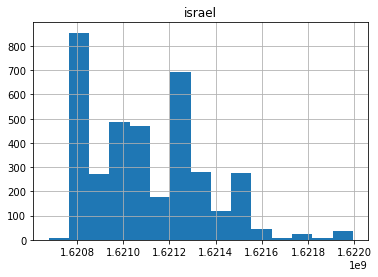

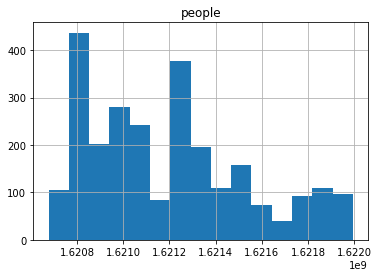

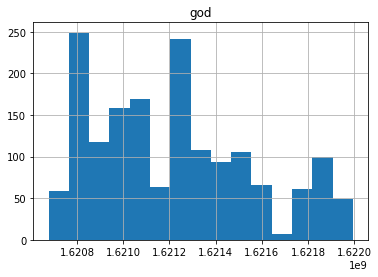

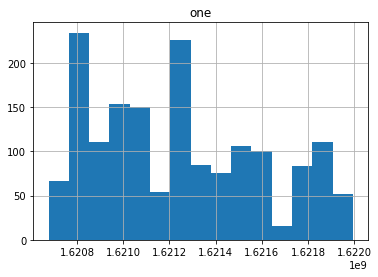

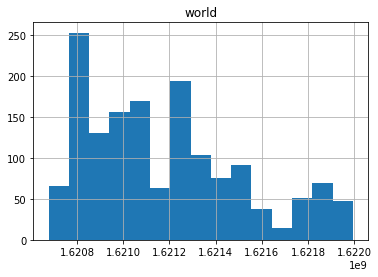

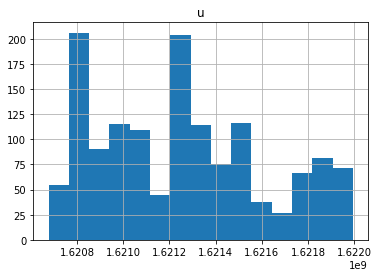

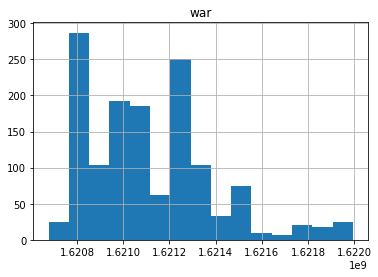

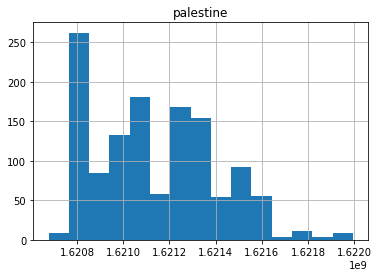

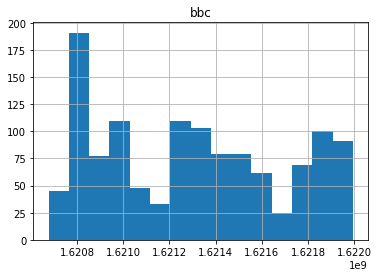

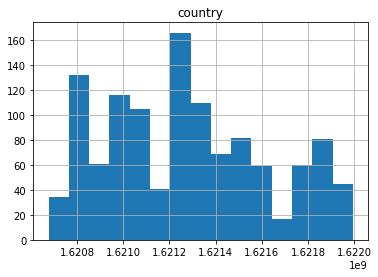

In [9]:
for word in freqDataFrame['word'].head(10):
    display(wordtimeDataFrame[wordtimeDataFrame['word'] == word].hist(bins=bins))
    plt.title(word)

In [14]:
vecDict = dict()
for word in tqdm(freqDataFrame['word'].head(100)):
    vecDict[word] = get_freq_vec(wordtimeDataFrame, word, bins)

word1 = []
word2 = []
similarity = []
for w1 in vecDict:
    for w2 in vecDict:
        if w1 == w2:
            break

        word1.append(w1)
        word2.append(w2)
        similarity.append(np.dot(vecDict[w1], vecDict[w2]))

similarityDataFrame = pd.DataFrame(columns=['word1', 'word2', 'similarity'], data={
    'word1': word1,
    'word2': word2,
    'similarity': similarity
}).sort_values(by='similarity', ascending=False)

similarityDataFrame[:30]

100%|██████████| 100/100 [00:02<00:00, 41.77it/s]


,word1,word2,similarity
236,would,u,0.994638
15,war,israel,0.994634
7,world,people,0.994633
4571,really,like,0.993900
257,need,world,0.993867
961,make,time,0.993000
1280,think,u,0.992888
5,one,god,0.992884
45,palestinian,israel,0.992735
325,gaza,israel,0.992392


In [15]:
freqList = [get_freq(comments) for comments in tqdm(commentsList)]

100%|██████████| 50/50 [00:04<00:00, 11.59it/s]


In [16]:
def tf(w, i):
    filtered = [*freqList[i][freqList[i]['word'] == w]['freq']]
    
    if not filtered: return 0
    else: return filtered[0]

def idf(w):
    f = sum([(1 if w in eldf['word'] else 0) for eldf in freqList])
    return np.log(len(freqList) / (f + 1))

def tf_idf(w):
    idfOfWord = idf(w)
    return [tf(w, i) * idfOfWord for i in range(len(freqList))]

In [17]:
tf_idf('israel')

[3.912023005428146,
 43.0322530597096,
 82.15248311399107,
 0.0,
 3.912023005428146,
 0.0,
 19.56011502714073,
 15.648092021712584,
 0.0,
 35.20820704885331,
 35.20820704885331,
 0.0,
 3.912023005428146,
 27.38416103799702,
 0.0,
 3.912023005428146,
 101.71259814113179,
 58.68034508142219,
 3.912023005428146,
 1236.1992697152941,
 7.824046010856292,
 15.648092021712584,
 0.0,
 27.38416103799702,
 0.0,
 0.0,
 19.56011502714073,
 0.0,
 35.20820704885331,
 1255.7593847424348,
 2409.806171343738,
 23.472138032568875,
 82.15248311399107,
 418.5864615808116,
 2069.460169871489,
 0.0,
 23.472138032568875,
 2159.4366989963364,
 7.824046010856292,
 872.3811302104765,
 2296.357504186322,
 11.736069016284437,
 0.0,
 3.912023005428146,
 3.912023005428146,
 3.912023005428146,
 0.0,
 0.0,
 3.912023005428146,
 1216.6391546881534]

In [48]:
# 데이터 저장

with open('data/videoid.txt', 'w') as f:
    f.write(str(videoIdList))
with open('data/statistics.txt', 'w') as f:
    f.write(str(statisticsList))
with open('data/comments.txt', 'w') as f:
    f.write(str(commentsList))
with open('data/timestamp.txt', 'w') as f:
    f.write(str(commentsTimestamp))